<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#UK-Commentary" data-toc-modified-id="UK-Commentary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>UK Commentary</a></span></li></ul></div>

## UK Commentary
Official figures are here:
* https://www.gov.uk/guidance/coronavirus-covid-19-information-for-the-public#number-of-cases-and-deaths

In [1]:
import sys
from os import path
sys.path.append(path.pardir)
from src.covid import CovidCountry

# Load and fix UK data
fix_data = {'2020-03-12': 590,
               '2020-03-15': 1391,
               '2020-03-19': 3269,}

uk = CovidCountry(country='United Kingdom',
                  province=True,
                  filepath='../data/raw/',
                  fixes=fix_data)

uk.load(today=70272)
uk.fit(start_str='2020-02-26',
       duration_guess=7*13,
       peak_guess=130000)

gb_df = uk.predict()

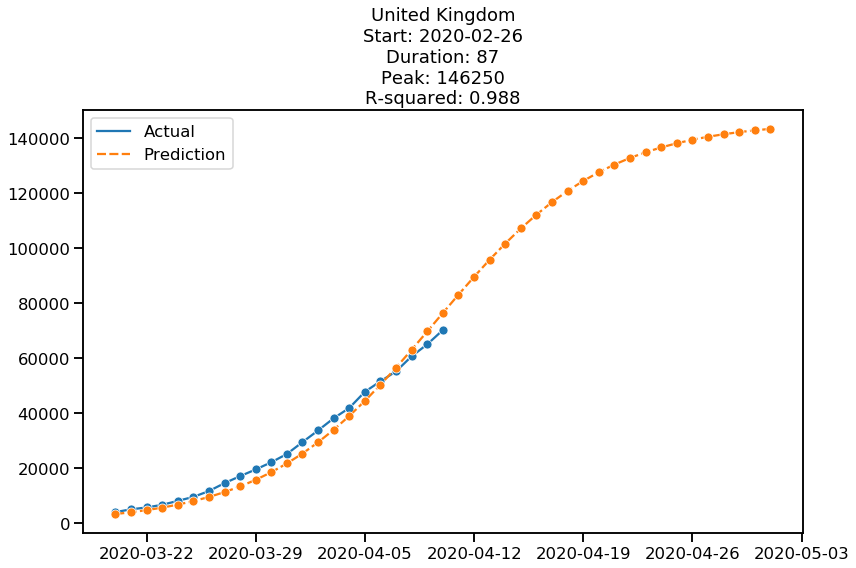

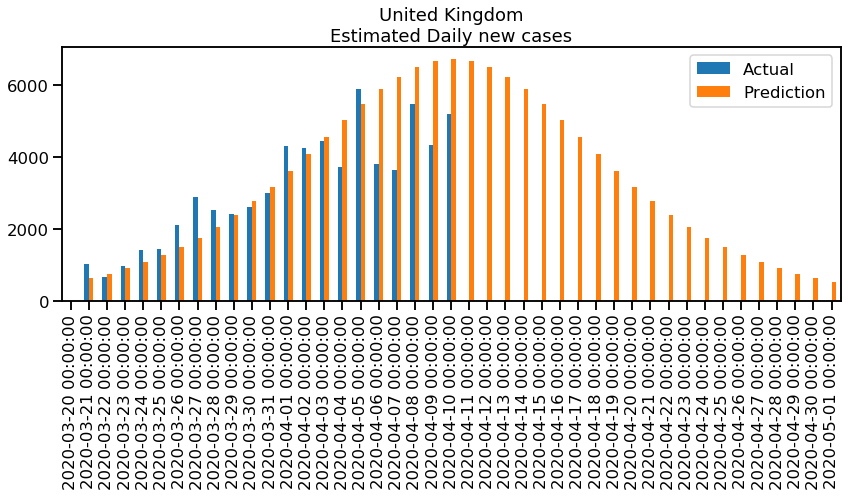

In [3]:
uk.display(offset=21)